In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Callable
from scipy.stats import norm

sns.set_style('whitegrid')
sns.set_palette('rocket')


## Euler-Maruyuama Scheme

$$ X_{i+1} = X_{i} + \mu(X_i,t_i) \Delta t + \sigma(X_i , t_i) \sqrt{\Delta t} Z_i , \quad Z_i \sim N(0,1) $$

In [2]:
def euler_scheme(
        drift: Callable[[float, float], float], 
        vol: Callable[[float, float], float], 
        X_0: float, 
        T: float, 
        delta_t: float
):
    N = int(T/delta_t + 1)
    t = np.linspace(0, T, N)
    X = np.zeros(N)
    X[0] = X_0
    for i in range(N-1):
        X[i+1] = X[i] + drift(X[i], t[i]) * delta_t + vol(X[i], t[i]) * np.sqrt(delta_t) * np.random.normal()
    return t, X

def euler_scheme_antithetic(
        drift: Callable[[float, float], float], 
        vol: Callable[[float, float], float], 
        X_0: float, 
        T: float, 
        delta_t: float
):
    N = int(T/delta_t + 1)
    t = np.linspace(0, T, N)
    X1 = np.zeros(N)
    X2 = np.zeros(N)
    X1[0] = X_0
    X2[0] = X_0
    for i in range(N-1):
        Zi = np.random.normal()
        X1[i+1] = X1[i] + drift(X1[i], t[i]) * delta_t + vol(X1[i], t[i]) * np.sqrt(delta_t) * Zi
        X2[i+1] = X2[i] + drift(X2[i], t[i]) * delta_t + vol(X2[i], t[i]) * np.sqrt(delta_t) * -Zi
    return t, X1 , X2

## Milstein Scheme

$$ X_{i+1} = X_{i} + \mu(X_i,t_i) \Delta t + \sigma(X_i , t_i) \sqrt{\Delta t} Z_i + \frac{1}{2} \sigma'(X_i,t_i) \sigma(X_i,t_i) \Delta t(Z_i^2 - 1) , \quad Z_i \sim N(0,1) $$

In [3]:
def milstein_scheme(
        drift: Callable[[float, float], float], 
        vol: Callable[[float, float], float], 
        vol_prime: Callable[[float, float], float], 
        X_0: float, 
        T: float, 
        delta_t: float
):
    N = int(T/delta_t + 1)
    t = np.linspace(0, T, N)
    X = np.zeros(N)
    X[0] = X_0
    for i in range(N-1):
        Z_i = np.random.normal()
        X[i+1] = X[i] + drift(X[i], t[i]) * delta_t + vol(X[i], t[i]) * np.sqrt(delta_t) * Z_i + 1/2 * vol_prime(X[i], t[i]) * vol(X[i], t[i]) * delta_t * (Z_i**2 - 1)
    return t, X

def milstein_scheme_antithetic(
        drift: Callable[[float, float], float], 
        vol: Callable[[float, float], float], 
        vol_prime: Callable[[float, float], float], 
        X_0: float, 
        T: float, 
        delta_t: float
):
    N = int(T/delta_t + 1)
    t = np.linspace(0, T, N)
    X1 = np.zeros(N)
    X2 = np.zeros(N)
    X1[0] = X_0
    X2[0] = X_0
    for i in range(N-1):
        Z_i = np.random.normal()
        X1[i+1] = X1[i] + drift(X1[i], t[i]) * delta_t + vol(X1[i], t[i]) * np.sqrt(delta_t) * Z_i + 1/2 * vol_prime(X1[i], t[i]) * vol(X1[i], t[i]) * delta_t * (Z_i**2 - 1)
        X2[i+1] = X2[i] + drift(X2[i], t[i]) * delta_t + vol(X2[i], t[i]) * np.sqrt(delta_t) * -Z_i + 1/2 * vol_prime(X2[i], t[i]) * vol(X2[i], t[i]) * delta_t * ((-Z_i)**2 - 1)
    return t, X1 , X2

In [4]:
class GBM():
    def __init__(self, mu, sigma, X_0, T, delta_t):
        self.mu = mu
        self.sigma = sigma
        self.X_0 = X_0
        self.T = T
        self.delta_t = delta_t
        
    def drift(self, X, t):
        return self.mu * X
    
    def vol(self, X, t):
        return self.sigma * X
    
    def vol_prime(self, X, t):
        return self.sigma
    
    def simulate(self):
        N = int(self.T/self.delta_t + 1)
        t = np.linspace(0, self.T, N)
        log_returns = (self.mu - self.mu**2 / 2) * self.delta_t + self.sigma * np.sqrt(self.delta_t) * np.random.normal(size = N-1)
        X = self.X_0 * np.exp(np.cumsum(np.insert(log_returns, 0, 0)))
        return t, X
    
    def simulate_antithetic(self):
        N = int(self.T/self.delta_t + 1)
        t = np.linspace(0, self.T, N)
        Zi = np.random.normal(size = N-1)
        log_returns1 = (self.mu - self.mu**2 / 2) * self.delta_t + self.sigma * np.sqrt(self.delta_t) * Zi
        log_returns2 = (self.mu - self.mu**2 / 2) * self.delta_t + self.sigma * np.sqrt(self.delta_t) * -Zi
        X1 = self.X_0 * np.exp(np.cumsum(np.insert(log_returns1, 0, 0)))
        X2 = self.X_0 * np.exp(np.cumsum(np.insert(log_returns2, 0, 0)))
        return t, X1 , X2

    def simulate_euler(self):
        return euler_scheme(lambda X, t: self.drift(X, t), lambda X, t: self.vol(X, t), self.X_0, self.T, self.delta_t)

    def simulate_euler_antithetic(self):
        return euler_scheme_antithetic(lambda X, t: self.drift(X, t), lambda X, t: self.vol(X, t), self.X_0, self.T, self.delta_t)

    def simulate_milstein(self):
        return milstein_scheme(lambda X, t: self.drift(X, t), lambda X, t: self.vol(X, t), lambda X, t: self.vol_prime(X, t), self.X_0, self.T, self.delta_t)
    
    def simulate_milstein_antithetic(self):
        return milstein_scheme_antithetic(lambda X, t: self.drift(X, t), lambda X, t: self.vol(X, t), lambda X, t: self.vol_prime(X, t), self.X_0, self.T, self.delta_t)

class Option:
    def __init__(self, S_0, K, T, r, sigma, delta_t):
        self.S_0 = S_0  
        self.K = K      
        self.T = T      
        self.r = r      
        self.sigma = sigma  
        self.delta_t = delta_t 

        self.gbm = GBM(mu=self.r, sigma=self.sigma, X_0=self.S_0, T=self.T, delta_t=self.delta_t)

    def BlackScholes(self, call =True):
        d1 = (np.log(self.S_0 / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)
        if call:
            return self.S_0 * norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2)
        else:
            return self.K * np.exp(-self.r * self.T) * norm.cdf(-d2) - self.S_0 * norm.cdf(-d1)
        
    def payoff(self,X,call=True):
        if call:
            return np.maximum( X - self.K , 0 )
        else:
            return np.maximum( self.K - X , 0 )

    def Monte_Carlo(self, simulation_function = 1 , call=True , nsim = 1000):
        payoffs = np.zeros( nsim )
        if simulation_function == 1:
            simulate_func = self.gbm.simulate

        if simulation_function == 2:
            simulate_func = self.gbm.simulate_euler
        
        if simulation_function == 3:
            simulate_func = self.gbm.simulate_milstein
        
        for i in range( nsim ):
            t,X = simulate_func()
            payoffs[i] = self.payoff( X[-1] )
        return np.exp( -self.r * self.T ) * np.mean(payoffs)
    
    def Monte_Carlo_Antithetic( self , simulation_function = 1 , call = True , nsim = 1000):
        payoffs = np.zeros( nsim )
        if simulation_function == 1:
            simulate_func = self.gbm.simulate_antithetic

        if simulation_function == 2:
            simulate_func = self.gbm.simulate_euler_antithetic
        
        if simulation_function == 3:
            simulate_func = self.gbm.simulate_milstein_antithetic

        for i in range( nsim ):
            t,X1,X2 = simulate_func()
            payoffs[i] = .5 * ( self.payoff( X1[-1] ) +  self.payoff( X2[-1] ))
        
        return np.exp( -self.r * self.T ) * np.mean( payoffs )
    
    def Monte_Carlo_Control( self , simulation_function = 1 , call = True , nsim = 1000):
        payoffs = np.zeros( nsim )
        control = np.zeros( nsim )

        if simulation_function == 1:
            simulate_func = self.gbm.simulate

        if simulation_function == 2:
            simulate_func = self.gbm.simulate_euler
        
        if simulation_function == 3:
            simulate_func = self.gbm.simulate_milstein
        
        for i in range( nsim ):
            t,X = simulate_func()
            payoffs[i] = self.payoff( X[-1] )
            control[i] = X[-1]

        c = - np.cov( payoffs , control ,ddof=1)[0,1] / np.var( control , ddof=1 )
        adjusted_payoff = np.mean( payoffs ) + c * ( np.mean(control) - self.S_0* np.exp(self.r * self.T))

        return np.exp( -self.r * self.T ) * np.mean( adjusted_payoff )

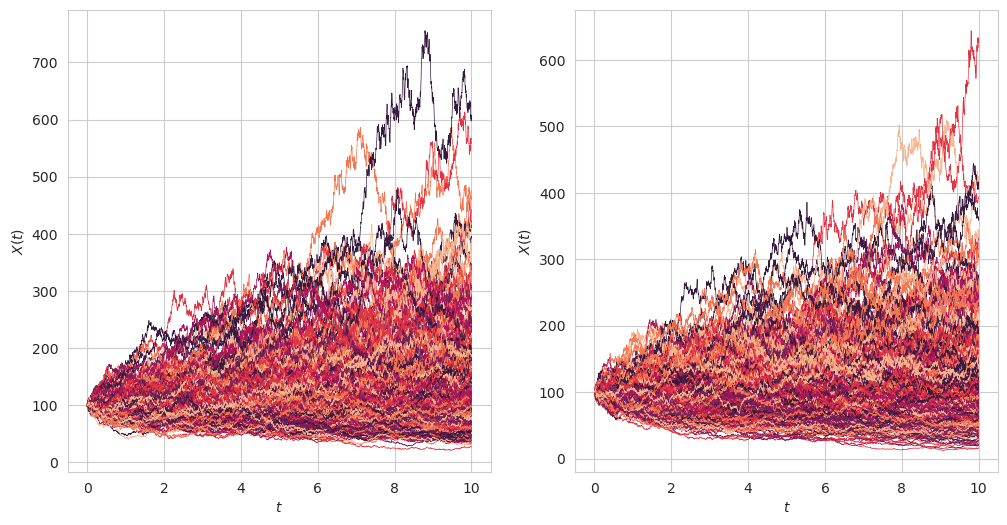

In [5]:
fig , axes = plt.subplots( 1,2 , figsize = (12,6))

gbm = GBM(0.02, 0.2, 100, 10, 1/252)
for _ in range(300):
    t, X = gbm.simulate()
    t, X_euler = gbm.simulate_euler()
    axes[0].plot(t, X, linewidth = 0.5)
    axes[0].set_xlabel('$t$')
    axes[0].set_ylabel('$X(t)$')

    axes[1].plot(t, X_euler, linewidth = 0.5)
    axes[1].set_xlabel('$t$')
    axes[1].set_ylabel('$X(t)$')

plt.show()

# Variance Reduction Techniques

In [6]:
S_0 = 100  
K = 100    
T = 1      
r = 0.05   
sigma = 0.2  
delta_t = 0.01  
nsims = range( 10 , 1000 )

option = Option(S_0, K, T, r, sigma, delta_t)

## Basic Monte Carlo

$$ <C(T)> = \exp(-rT) \frac{1}{N} \sum_{i=1}^{N}(S(T)^{(i)} - K) $$

In [7]:
call_basic = np.array( [option.Monte_Carlo(  simulation_function=1 ,nsim=i ) for i in nsims ] ) 
call_euler = np.array( [option.Monte_Carlo(  simulation_function=2 ,nsim=i ) for i in nsims ] ) 
call_milstein = np.array( [option.Monte_Carlo(  simulation_function=3 ,nsim=i ) for i in nsims ] ) 

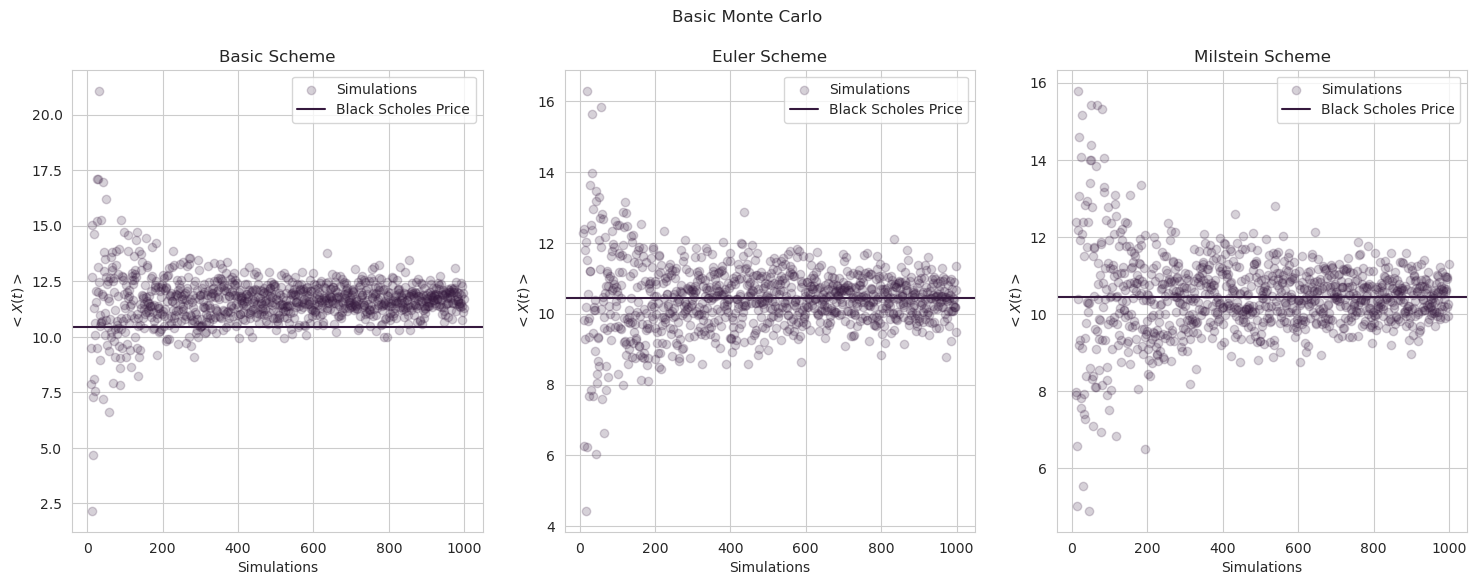

In [8]:
fig , axes = plt.subplots( 1,3 , figsize = (18,6))
fig.suptitle("Basic Monte Carlo")

axes[0].scatter( nsims , call_basic , alpha = .2 , label = "Simulations")
axes[0].axhline( y=option.BlackScholes() , label = "Black Scholes Price")
axes[0].set_xlabel('Simulations')
axes[0].set_ylabel('$<X(t)>$')
axes[0].set_title('Basic Scheme')
axes[0].legend()

axes[1].scatter( nsims , call_euler , alpha = .2 , label = "Simulations")
axes[1].axhline( y=option.BlackScholes() , label = "Black Scholes Price")
axes[1].set_xlabel('Simulations')
axes[1].set_ylabel('$<X(t)>$')
axes[1].set_title('Euler Scheme')
axes[1].legend()

axes[2].scatter( nsims , call_milstein , alpha = .2 , label = "Simulations")
axes[2].axhline( y=option.BlackScholes() , label = "Black Scholes Price")
axes[2].set_xlabel('Simulations')
axes[2].set_ylabel('$<X(t)>$')
axes[2].set_title('Milstein Scheme')
axes[2].legend()


## Antithetic Monte Carlo Method

$$ <C(T)> = \sum_{i=1}^{N} \frac{1}{2} (C^{(i)}_+(T) + C^{(i)}_-(T)) $$

$$ C^{+}(T) = \max{ S^{(i)}_{+}(T) - K , 0 } $$

$$ S_{+,j+1} = S_{+,j} + \mu(S_{+,j},t_i) \Delta t + \sigma(S_{+,j} , t_i) \sqrt{\Delta t} Z_i , \quad Z_i \sim N(0,1) $$
$$ S_{-,j+1} = S_{-,j} + \mu(S_{-,j},t_i) \Delta t - \sigma(S_{-,j} , t_i) \sqrt{\Delta t} Z_i , \quad Z_i \sim N(0,1) $$

In [9]:
call_basic = np.array( [option.Monte_Carlo_Antithetic(  simulation_function=1 ,nsim=i ) for i in nsims ] ) 
call_euler = np.array( [option.Monte_Carlo_Antithetic(  simulation_function=2 ,nsim=i ) for i in nsims ] ) 
call_milstein = np.array( [option.Monte_Carlo_Antithetic(  simulation_function=3 ,nsim=i ) for i in nsims ] ) 

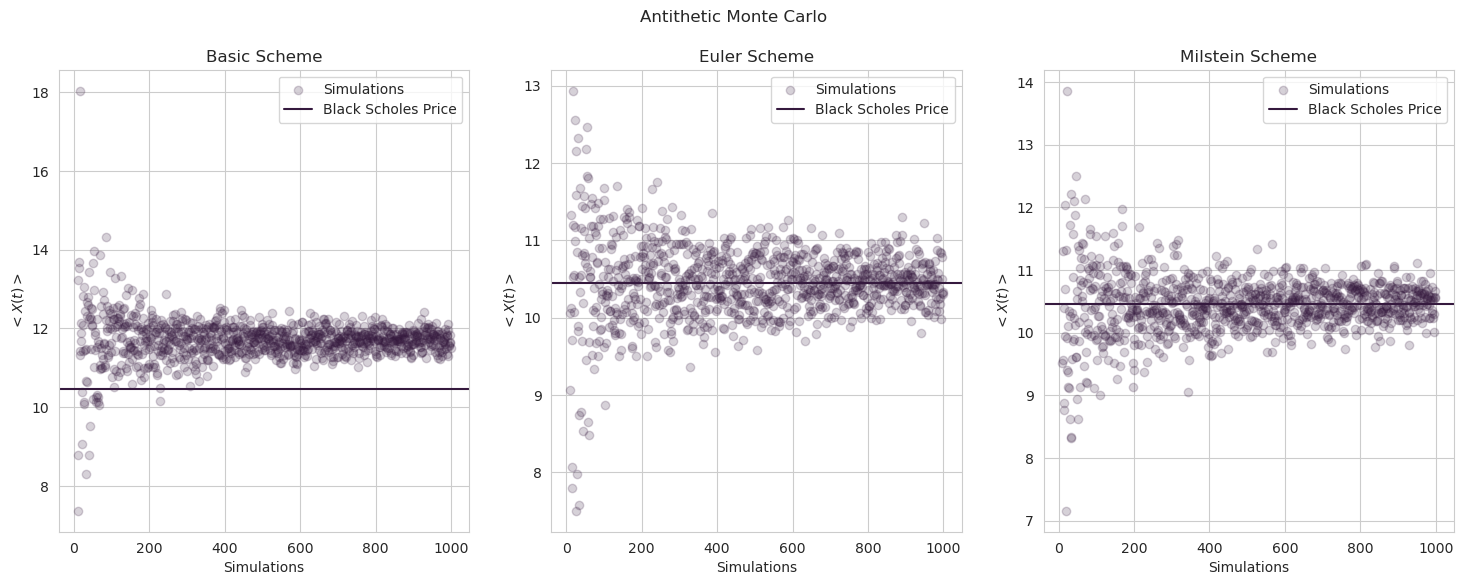

In [10]:
fig , axes = plt.subplots( 1,3 , figsize = (18,6))
fig.suptitle("Antithetic Monte Carlo")

axes[0].scatter( nsims , call_basic , alpha = .2 , label = "Simulations")
axes[0].axhline( y=option.BlackScholes() , label = "Black Scholes Price")
axes[0].set_xlabel('Simulations')
axes[0].set_ylabel('$<X(t)>$')
axes[0].set_title('Basic Scheme')
axes[0].legend()

axes[1].scatter( nsims , call_euler , alpha = .2 , label = "Simulations")
axes[1].axhline( y=option.BlackScholes() , label = "Black Scholes Price")
axes[1].set_xlabel('Simulations')
axes[1].set_ylabel('$<X(t)>$')
axes[1].set_title('Euler Scheme')
axes[1].legend()

axes[2].scatter( nsims , call_milstein , alpha = .2 , label = "Simulations")
axes[2].axhline( y=option.BlackScholes() , label = "Black Scholes Price")
axes[2].set_xlabel('Simulations')
axes[2].set_ylabel('$<X(t)>$')
axes[2].set_title('Milstein Scheme')
axes[2].legend()

## Variable Control Montecarlo Method

$$ <C(T)> = exp(-rT) \frac{1}{N} \sum_{i=1}^{N} (S(T)^{(i)} - K) + c( Z^{(i)} - E[Z] ) $$

$$ c = - \frac{cov[(S(T)^{(i)} - K) , Z]}{Var[Z]} $$

We chose 

$$ Z = S(T) \implies E[Z] = S(0) \exp( rT ) $$

In [11]:
call_basic = np.array( [option.Monte_Carlo_Control(  simulation_function=1 ,nsim=i ) for i in nsims ] ) 
call_euler = np.array( [option.Monte_Carlo_Control(  simulation_function=2 ,nsim=i ) for i in nsims ] ) 
call_milstein = np.array( [option.Monte_Carlo_Control(  simulation_function=3 ,nsim=i ) for i in nsims ] ) 

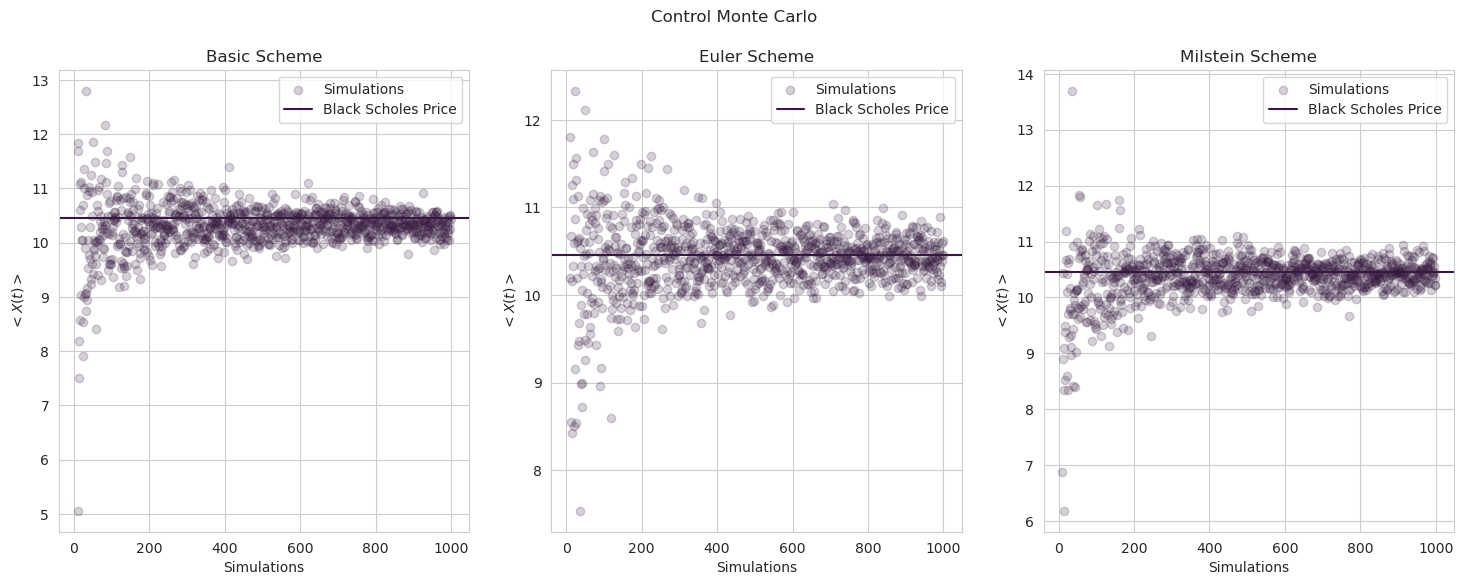

In [12]:
fig , axes = plt.subplots( 1,3 , figsize = (18,6))
fig.suptitle("Control Monte Carlo")

axes[0].scatter( nsims , call_basic , alpha = .2 , label = "Simulations")
axes[0].axhline( y=option.BlackScholes() , label = "Black Scholes Price")
axes[0].set_xlabel('Simulations')
axes[0].set_ylabel('$<X(t)>$')
axes[0].set_title('Basic Scheme')
axes[0].legend()

axes[1].scatter( nsims , call_euler , alpha = .2 , label = "Simulations")
axes[1].axhline( y=option.BlackScholes() , label = "Black Scholes Price")
axes[1].set_xlabel('Simulations')
axes[1].set_ylabel('$<X(t)>$')
axes[1].set_title('Euler Scheme')
axes[1].legend()

axes[2].scatter( nsims , call_milstein , alpha = .2 , label = "Simulations")
axes[2].axhline( y=option.BlackScholes() , label = "Black Scholes Price")
axes[2].set_xlabel('Simulations')
axes[2].set_ylabel('$<X(t)>$')
axes[2].set_title('Milstein Scheme')
axes[2].legend()